In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [2]:
import joblib
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from tqdm.notebook import tqdm
from IPython.core import pylabtools

tqdm.pandas()
pylabtools.figsize(16, 8)
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
df = pd.read_csv("../Data/BTC-USD.csv", parse_dates=['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-13,434.665009,435.186005,424.442993,432.371002,432.371002,173888000
1,2016-01-14,432.287994,433.324005,427.845001,430.306000,430.306000,43945500
2,2016-01-15,430.255005,430.255005,364.330994,364.330994,364.330994,153351008
3,2016-01-16,365.072998,390.557007,354.914001,387.536011,387.536011,120352000
4,2016-01-17,387.152008,390.964996,380.092010,382.299011,382.299011,45319600
...,...,...,...,...,...,...,...
2187,2022-01-08,41561.464844,42228.941406,40672.277344,41733.941406,41733.941406,28066355845
2188,2022-01-09,41734.726563,42663.949219,41338.160156,41911.601563,41911.601563,21294384372
2189,2022-01-10,41910.230469,42199.484375,39796.570313,41821.261719,41821.261719,32104232331
2190,2022-01-11,41819.507813,43001.156250,41407.753906,42735.855469,42735.855469,26327648900


In [5]:
df.set_index('Date', drop=False, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2016-01-13 to 2022-01-12
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2192 non-null   datetime64[ns]
 1   Open       2192 non-null   float64       
 2   High       2192 non-null   float64       
 3   Low        2192 non-null   float64       
 4   Close      2192 non-null   float64       
 5   Adj Close  2192 non-null   float64       
 6   Volume     2192 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.0 KB


In [7]:
all(df['Close'] == df['Adj Close'])

True

In [8]:
df['Date'] = df['Date'].astype('int64') // 10**9

<AxesSubplot:xlabel='Date', ylabel='Close'>

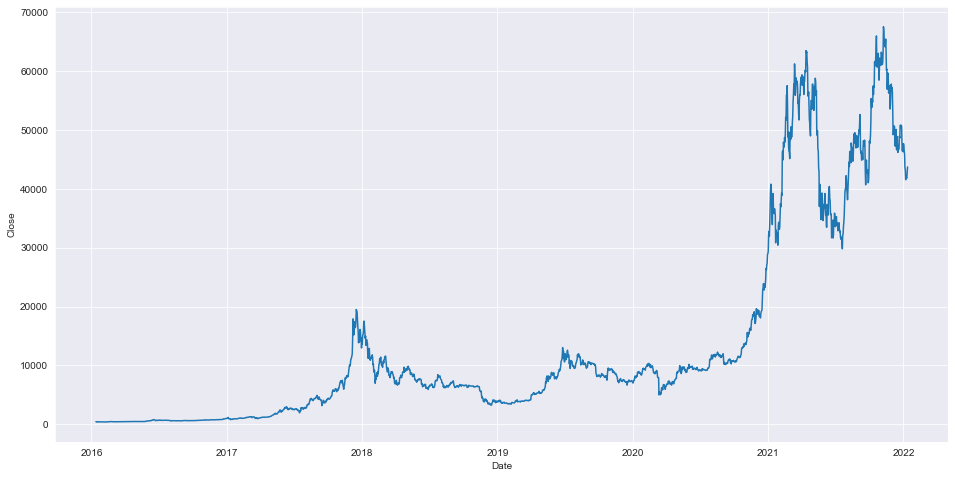

In [9]:
sns.lineplot(x=df.index, y='Close', data=df)

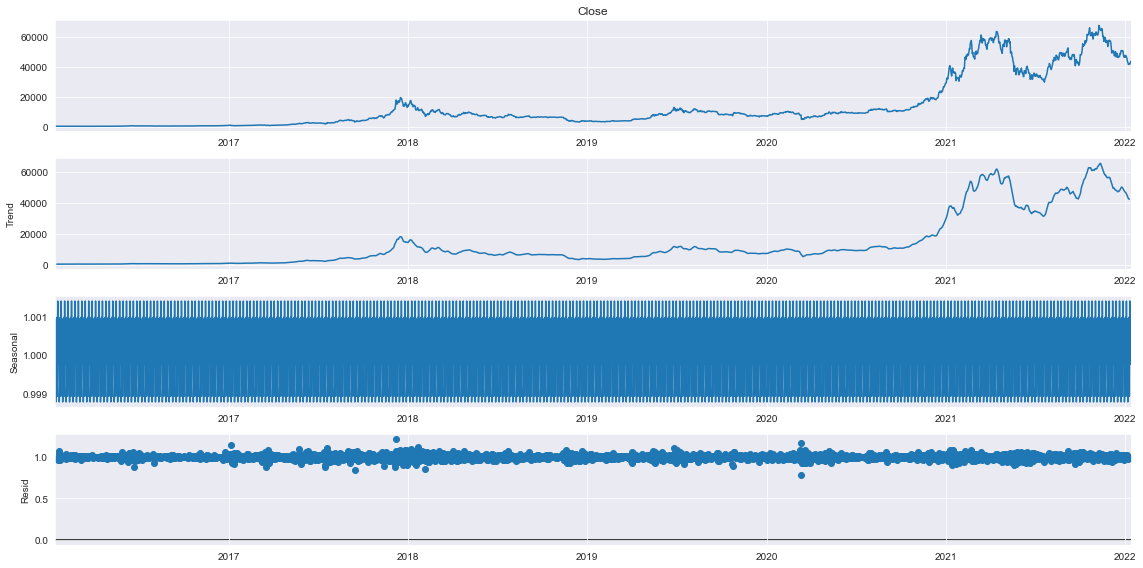

In [10]:
decompose_result = seasonal_decompose(df['Close'], model='multiplicative')
decompose_result.plot();

In [11]:
df.drop(columns=['High', 'Open', 'Low', 'Adj Close', 'Volume'], inplace=True)

In [12]:
# add past data as columns
for day in np.arange(7, 14)+1:
    df[f'Close-{day}'] = df['Close'].shift(day)

In [13]:
df

,Date,Close,Close-8,Close-9,Close-10,Close-11,Close-12,Close-13,Close-14
Date,,,,,,,,,
2016-01-13,1452643200,432.371002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-14,1452729600,430.306000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-15,1452816000,364.330994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-16,1452902400,387.536011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-17,1452988800,382.299011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-01-08,1641600000,41733.941406,46306.445313,47178.125000,46444.710938,47588.855469,50640.417969,50809.515625,50429.859375
2022-01-09,1641686400,41911.601563,47686.812500,46306.445313,47178.125000,46444.710938,47588.855469,50640.417969,50809.515625
2022-01-10,1641772800,41821.261719,47345.218750,47686.812500,46306.445313,47178.125000,46444.710938,47588.855469,50640.417969


In [14]:
df.dropna(inplace=True)

In [15]:
input_columns = ['Date', 'Close-8', 'Close-9', 'Close-10', 'Close-11', 'Close-12', 'Close-13', 'Close-14']
output_column = 'Close'

In [16]:
test_size = 200
X_train, X_test = df[input_columns][:-test_size], df[input_columns][-test_size:]
y_train, y_test = df[output_column][:-test_size], df[output_column][-test_size:]

In [17]:
_, (train_index,test_index) = TimeSeriesSplit(n_splits=2, test_size=200).split(X_train)
tscv = TimeSeriesSplit(test_size=100)

In [18]:
pipeline = Pipeline([
    ("date_to_log", ColumnTransformer(
        transformers=[
            (
                "date_to_log",
                FunctionTransformer(func=np.log1p, inverse_func=np.expm1),
                ["Date"]
            ),
            (
                "close_poly",
                PolynomialFeatures(degree=2),
                ['Close-8', 'Close-9', 'Close-10', 'Close-11', 'Close-12', 'Close-13', 'Close-14']
            )
        ]
    )),
    ("scaler", MinMaxScaler()),
])

In [19]:
regressors = {
    "lr": LinearRegression(),
    "rfg": RandomForestRegressor(),
    "xgbr": XGBRegressor(),
    'lgbmr': LGBMRegressor(),
    "extra": ExtraTreesRegressor(),
    "sgdr": SGDRegressor(),
    "ridge": RidgeCV(cv=tscv),
    "elastic": ElasticNetCV(cv=tscv),
    "lasso_lars": LassoLarsCV(cv=tscv),
    "ransac": RANSACRegressor(min_samples=100),
    "ada": AdaBoostRegressor(),
    "gbr": GradientBoostingRegressor(),
    "knr": KNeighborsRegressor(),
    "gpr": GaussianProcessRegressor(),
    "mlp": MLPRegressor(),
    "dtr": DecisionTreeRegressor(),
    "lsvr": LinearSVR(),
    "svr": SVR()
}

scores = {}

  0%|          | 0/18 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Date', ylabel='Close'>

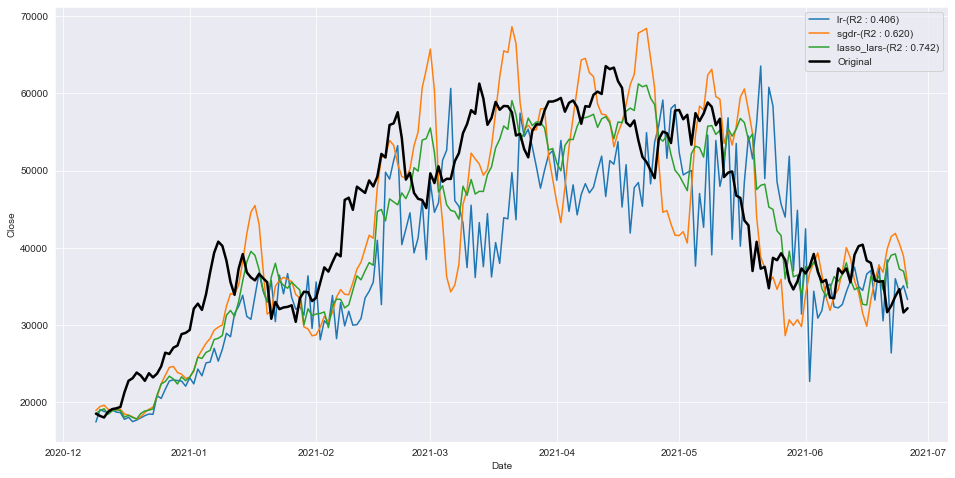

In [20]:
for name, model in tqdm(regressors.items()):
    # add the model as a step
    pipeline.steps.append((name, model))
    
    # training and prediction
    reg = pipeline.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    pred = pipeline.predict(X_train.iloc[test_index])
    
    # remove model from pipeline
    pipeline.steps.pop()
    
    # storing the scores
    scores[name] = {
        "r_square": r2_score(y_train.iloc[test_index], pred),
        "nrmse": -mean_squared_error(y_train.iloc[test_index], pred, squared=False),
        "nmape": -mean_absolute_percentage_error(y_train.iloc[test_index], pred)
    }
    
    # plot if r-square >= 0
    if scores[name]["r_square"] >= 0:
        sns.lineplot(
            x=X_train.iloc[test_index].index,
            y=pred,
            label=f"{name}-(R2 : {scores[name]['r_square']:.3f})"
        )
    
sns.lineplot(x=X_train.iloc[test_index].index, y=y_train.iloc[test_index], label='Original', linewidth=2.5, color='k')

In [21]:
score_data = pd.DataFrame(scores).T.sort_values('r_square', ascending=False)
score_data

,r_square,nrmse,nmape
lasso_lars,0.741978,-6086.556845,-0.116328
sgdr,0.619846,-7387.936982,-0.134999
lr,0.405788,-9236.639828,-0.167184
mlp,-0.147425,-12835.283765,-0.279066
ridge,-0.418619,-14271.720286,-0.243303
lsvr,-0.440172,-14379.722844,-0.278355
ransac,-0.440387,-14380.798764,-0.233636
elastic,-2.188850,-21397.370064,-0.370332
dtr,-4.128021,-27134.279178,-0.518097
knr,-4.198489,-27320.078349,-0.523020


In [22]:
while 'model' in pipeline.steps[-1]:
    pipeline.steps.pop()

In [23]:
pipeline.steps.append(
    (
        "model",
        StackingRegressor(
            estimators=[
                ("lasso_lars", make_pipeline(StandardScaler(with_mean=False), LassoLarsCV(cv=tscv))),
                ("lr", make_pipeline(StandardScaler(with_mean=False), LinearRegression())),
                ("sgd", SGDRegressor()),
            ]
        )
    )
)

In [24]:
final_estimators = [
    make_pipeline(StandardScaler(with_mean=False), LinearRegression()),
    RandomForestRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    ExtraTreesRegressor(),
    SGDRegressor(),
    RidgeCV(),
    ElasticNetCV(),
    make_pipeline(StandardScaler(with_mean=False), LassoLarsCV()),
    RANSACRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    GaussianProcessRegressor(),
    MLPRegressor(),
    DecisionTreeRegressor(),
    LinearSVR(),
    SVR()
]

In [25]:
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid={"model__final_estimator": final_estimators},
    n_jobs=-1,
    cv=tscv
).fit(X_train, y_train)

In [26]:
pipeline.set_params(**gscv.best_params_)

Pipeline(steps=[('date_to_log',
                 ColumnTransformer(transformers=[('date_to_log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      inverse_func=<ufunc 'expm1'>),
                                                  ['Date']),
                                                 ('close_poly',
                                                  PolynomialFeatures(),
                                                  ['Close-8', 'Close-9',
                                                   'Close-10', 'Close-11',
                                                   'Close-12', 'Close-13',
                                                   'Close-14'])])),
                ('scaler', MinMaxScaler()),
                ('model',
                 StackingRegressor(estimators=[('lasso_lars',
                                                Pipeline(steps=[('standardscaler',
       

In [27]:
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

<AxesSubplot:xlabel='Date', ylabel='Close'>

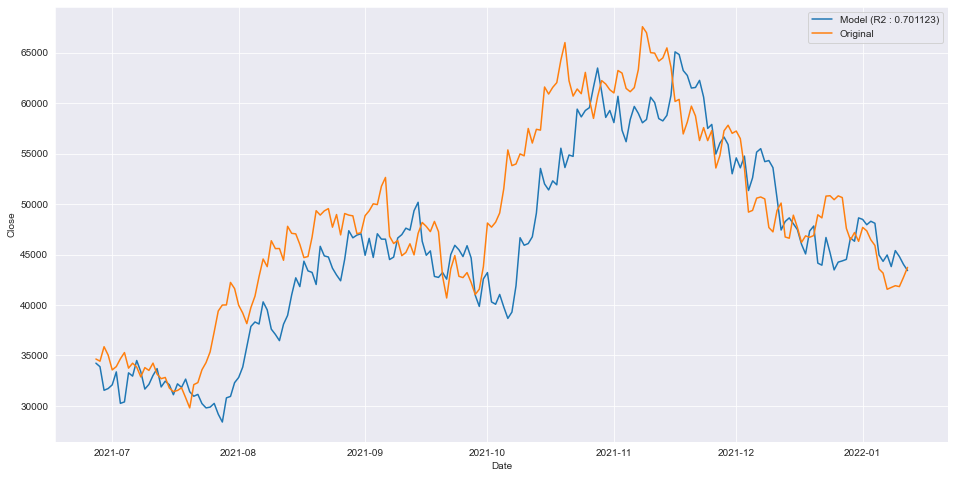

In [28]:
r_two = r2_score(y_test, pred)

sns.lineplot(x=X_test.index, y=pred, label=f"Model (R2 : {r_two:5f})")
sns.lineplot(x=X_test.index, y=y_test, label='Original')

In [29]:
joblib.dump(pipeline, "../Data/Bit Coin Price Prediction.pkl")

['../Data/Bit Coin Price Prediction.pkl']